In [ ]:
# Run this cell just once on your machine
!pip install s3fs

In [1]:
import json
import os
from matplotlib import pyplot as plt
import pandas as pd
import pickle
from s3fs.core import S3FileSystem
import numpy as np

c:\program files\python36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\program files\python36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\program files\python36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
MODEL_DIR = "mids-capstone-irrigation-detection/models"

In [26]:
s3_file = S3FileSystem()

datasets = {
    "balanced": "Balanced Dataset",
    "expanded": "Balanced and with Extended Labels",
}

In [65]:
def f_scores(scores):
    precision = scores[6]
    recall = scores[7]
    if precision + recall == 0.0:
        return [0.0, 0.0]
    f1 = (2 * precision * recall) / (precision + recall)
    beta = 0.5
    f05 = ((1 + beta) * precision * recall) / (beta * precision + recall)
    return [f1, f05]
    
def plot_results(plot_df, title=None):
    _title = "Dataset Split Percent vs F1 Score"
    if title is not None:
        _title += f" - {title}"
    plot_df = plot_df.sort_values("split_percent")
    plot_df.plot(kind="bar", figsize=(15,12), rot=0, ylim=(0.0, 1.0), fontsize=12, x='split_percent', y='f1',color='b')
    
    plt.title(_title, fontsize=22)
    plt.legend(fontsize=12)
    plt.xlabel("F1 Score", fontsize=18)
    plt.ylabel("Split Percent", fontsize=18)

def display_results(df = None):
    if df is None:
        df = load_results()
    for dataset, desc in datasets.items():
        _df = df[df.dataset == dataset]
        
        line = "=" * len(desc) + "=="
        print(f"\n\n{line}\n {desc}\n{line}")
        display(_df.sort_values("split_percent"))

        plot_results(_df, desc)
        plt.savefig(f"{dataset}.png")
        

In [66]:
def load_finetune_results() :
    data = []
    files = s3_file.glob(MODEL_DIR+"/CA_finetune/*.json")
    #print([x.split('/')[-1] for x in files])
    
    for f in files :
        r=json.load(s3_file.open(f))
        dataset,percent = f.split('/')[-1].split('_')[0:2]
        #print(dataset,percent, r['score'])
        
        score = [dataset, int(percent)] + r["score"] + f_scores(r["score"])
        data.append(score)
    
    df = pd.DataFrame(data)
    df.columns = ["dataset","split_percent","loss","tp","fp","tn","fn","accuracy","precision","recall","auc","f1","f0.5"]
    df.split_percent = pd.to_numeric(df.split_percent, errors='coerce')
    return df



 Balanced Dataset


,dataset,split_percent,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,f1,f0.5
1,balanced,1,0.575293,1507.0,435.0,1597.0,525.0,0.763780,0.776004,0.741634,0.830666,0.758430,0.764199
3,balanced,3,0.516939,1596.0,391.0,1638.0,439.0,0.795768,0.803221,0.784275,0.879051,0.793635,0.796805
0,balanced,10,0.391993,1586.0,238.0,1795.0,445.0,0.831939,0.869518,0.780896,0.921677,0.822828,0.837824
2,balanced,25,0.593542,1810.0,339.0,1691.0,224.0,0.861467,0.842252,0.889872,0.921659,0.865408,0.857549
4,balanced,50,0.285803,1859.0,270.0,1760.0,175.0,0.890502,0.873180,0.913963,0.945964,0.893106,0.886364




 Balanced and with Extended Labels


,dataset,split_percent,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,f1,f0.5
6,expanded,1,0.940654,4026.0,1217.0,4266.0,1467.0,0.755466,0.767881,0.732933,0.826695,0.750000,0.755867
8,expanded,3,0.443813,4726.0,1439.0,4048.0,763.0,0.799380,0.766586,0.860995,0.875605,0.811052,0.795668
5,expanded,10,0.411874,4592.0,1042.0,4448.0,894.0,0.823615,0.815051,0.837040,0.899441,0.825899,0.822251
7,expanded,25,0.724969,4006.0,729.0,4757.0,1484.0,0.798378,0.846040,0.729690,0.881289,0.783570,0.803342
9,expanded,50,0.347386,4746.0,867.0,4625.0,738.0,0.853772,0.845537,0.865427,0.923939,0.855366,0.852065


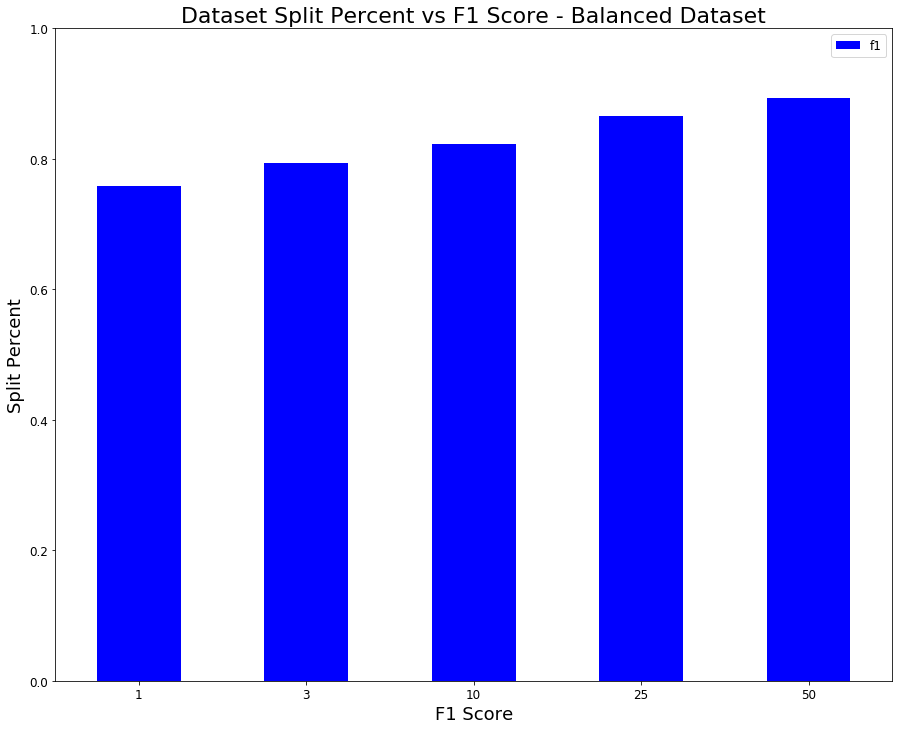

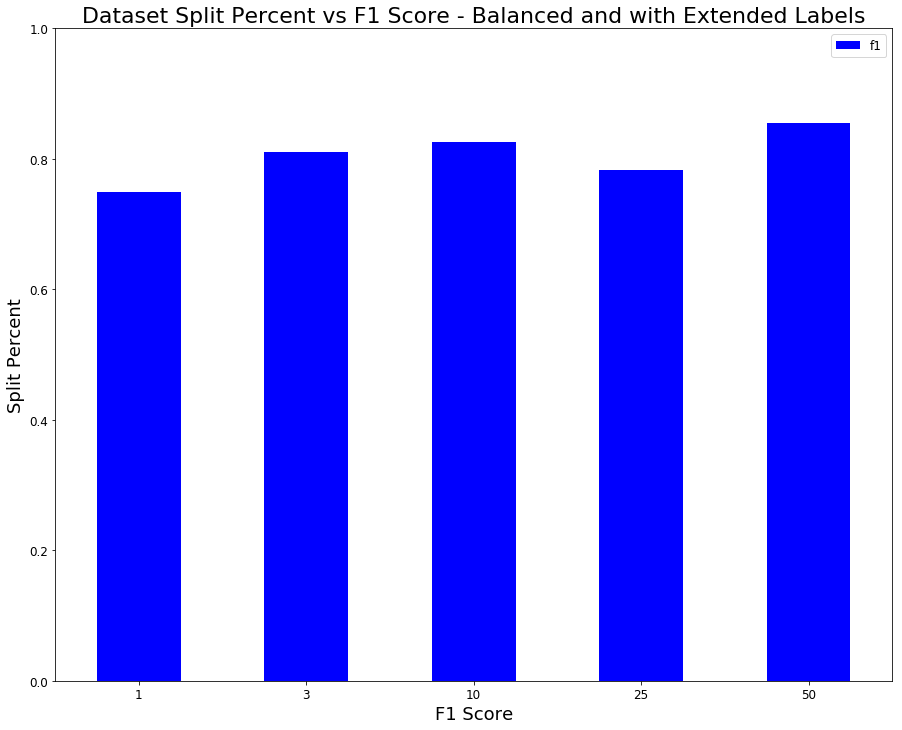

In [72]:
df = load_finetune_results()
display_results(df)

In [41]:
def f_scores2(scores):
    precision = scores['precision']
    recall = scores['recall']
    if precision + recall == 0.0:
        return [0.0, 0.0]
    f1 = (2 * precision * recall) / (precision + recall)
    beta = 0.5
    f05 = ((1 + beta) * precision * recall) / (beta * precision + recall)
    return [f1, f05]
    

In [50]:
def load_distill_results() :
    data = []
    files = s3_file.glob(MODEL_DIR+"/CA_distill/*.pkl")
    #print([x.split('/')[-1] for x in files])
    
    for f in files :
        r=pd.read_pickle(s3_file.open(f))
        f_split = f.split('/')[-1].split('.')[0].split('_')
        
        dataset = f_split[0]
        percent = f_split[1]
        arch = f_split[-1]
        
        score = [dataset, int(percent), arch] + f_scores(r["student"])
        data.append(score)
    
    df = pd.DataFrame(data)
    df.columns = ["dataset","split_percent","arch","f1","f0.5"]
    df.split_percent = pd.to_numeric(df.split_percent, errors='coerce')
    return df

In [55]:
distill_df = load_distill_results()



 Balanced Dataset


,dataset,split_percent,arch,f1,f0.5
5,balanced,1,InceptionV3,0.625638,0.675308
6,balanced,1,ResNet101V2,0.626196,0.674903
7,balanced,1,ResNet152,0.655870,0.696846
8,balanced,1,ResNet50,0.653935,0.694530
9,balanced,1,Xception,0.630339,0.674937
19,balanced,3,Xception,0.833947,0.832653
18,balanced,3,ResNet50,0.833047,0.831485
17,balanced,3,ResNet152,0.829582,0.831158
16,balanced,3,ResNet101V2,0.834109,0.833225
15,balanced,3,InceptionV3,0.834240,0.835343




 Balanced and with Extended Labels


,dataset,split_percent,arch,f1,f0.5
30,expanded,1,InceptionV3,0.698761,0.728742
31,expanded,1,ResNet101V2,0.696855,0.727331
32,expanded,1,ResNet152,0.679864,0.702770
33,expanded,1,ResNet50,0.695295,0.726076
34,expanded,1,Xception,0.697498,0.727850
44,expanded,3,Xception,0.831973,0.813886
43,expanded,3,ResNet50,0.830417,0.813409
42,expanded,3,ResNet152,0.833793,0.811638
41,expanded,3,ResNet101V2,0.831818,0.813813
40,expanded,3,InceptionV3,0.830575,0.813004


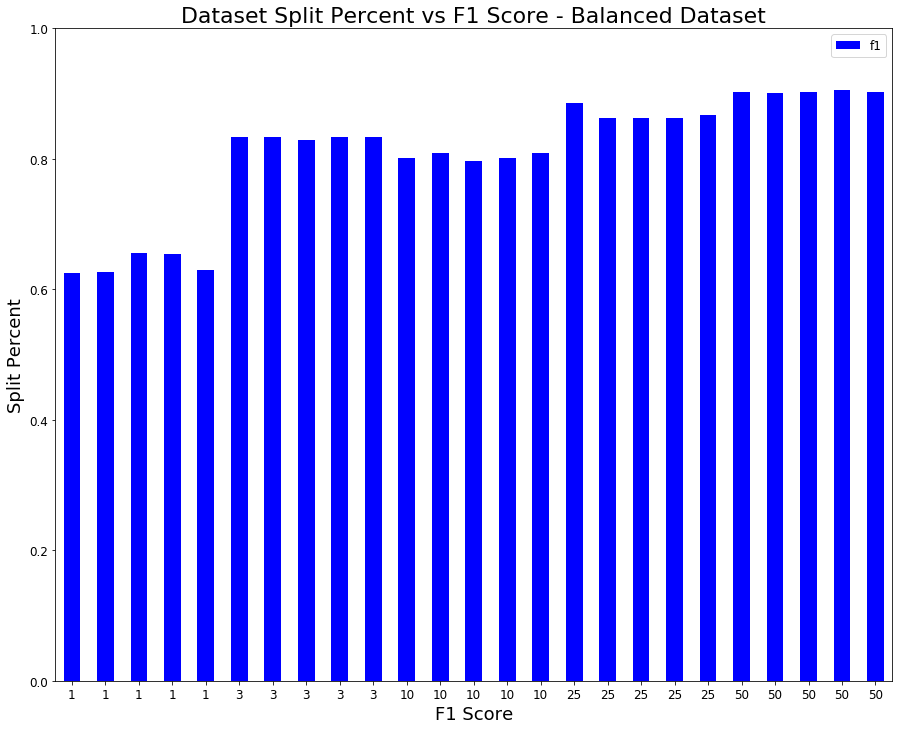

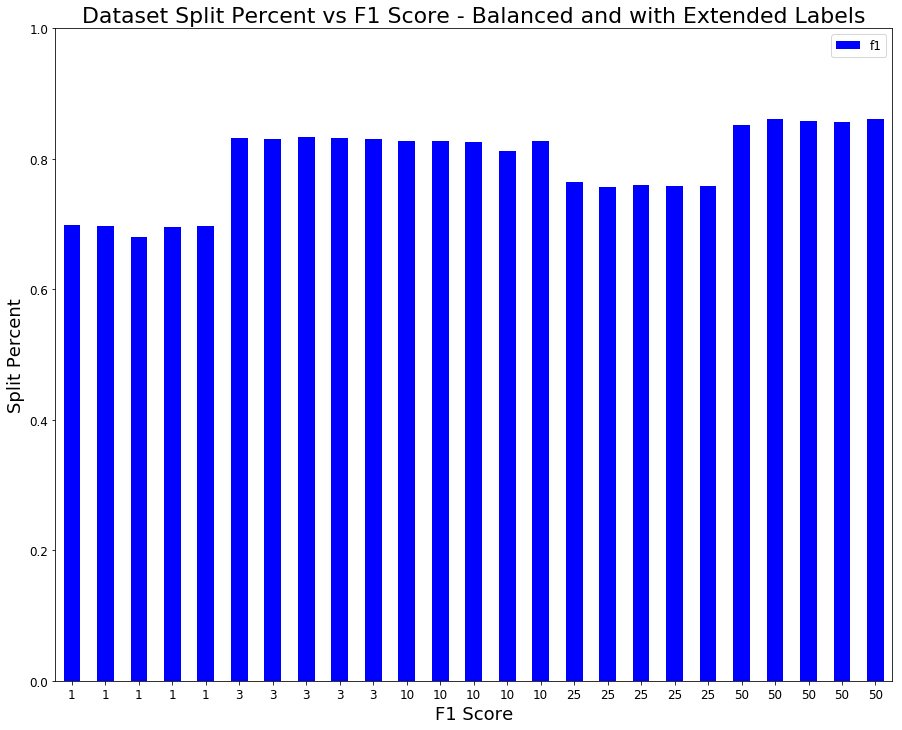

In [69]:
display_results(distill_df)



 Balanced Dataset


,dataset,split_percent,arch,f1,f0.5
8,balanced,1,ResNet50,0.653935,0.694530
18,balanced,3,ResNet50,0.833047,0.831485
3,balanced,10,ResNet50,0.801090,0.830665
13,balanced,25,ResNet50,0.863122,0.863263
23,balanced,50,ResNet50,0.902943,0.899225




 Balanced and with Extended Labels


,dataset,split_percent,arch,f1,f0.5
33,expanded,1,ResNet50,0.695295,0.726076
43,expanded,3,ResNet50,0.830417,0.813409
28,expanded,10,ResNet50,0.811804,0.816654
38,expanded,25,ResNet50,0.757021,0.776135
48,expanded,50,ResNet50,0.851558,0.848298


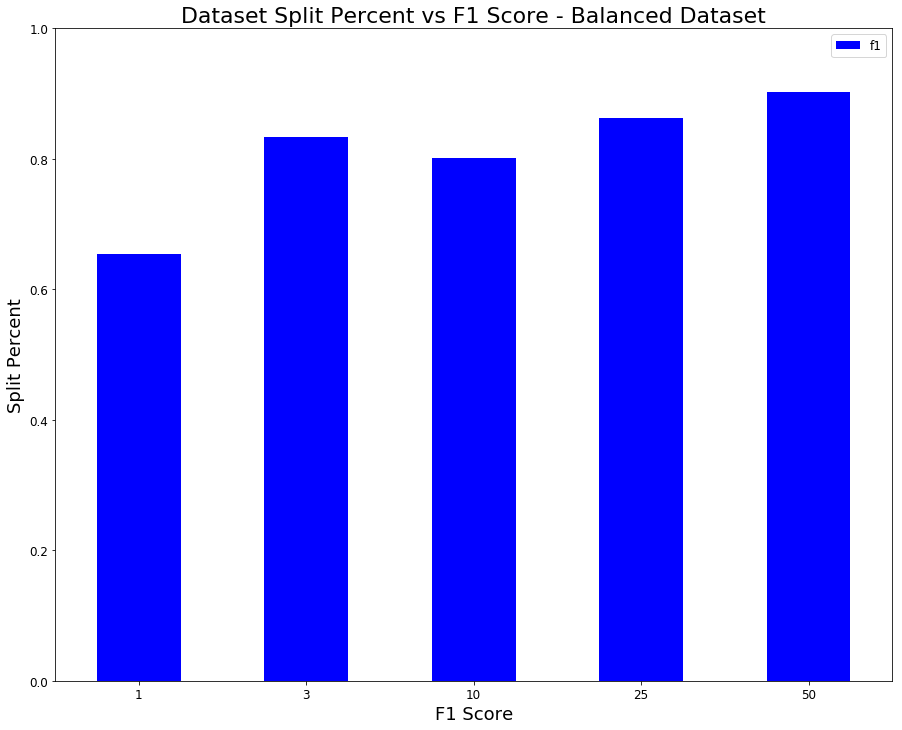

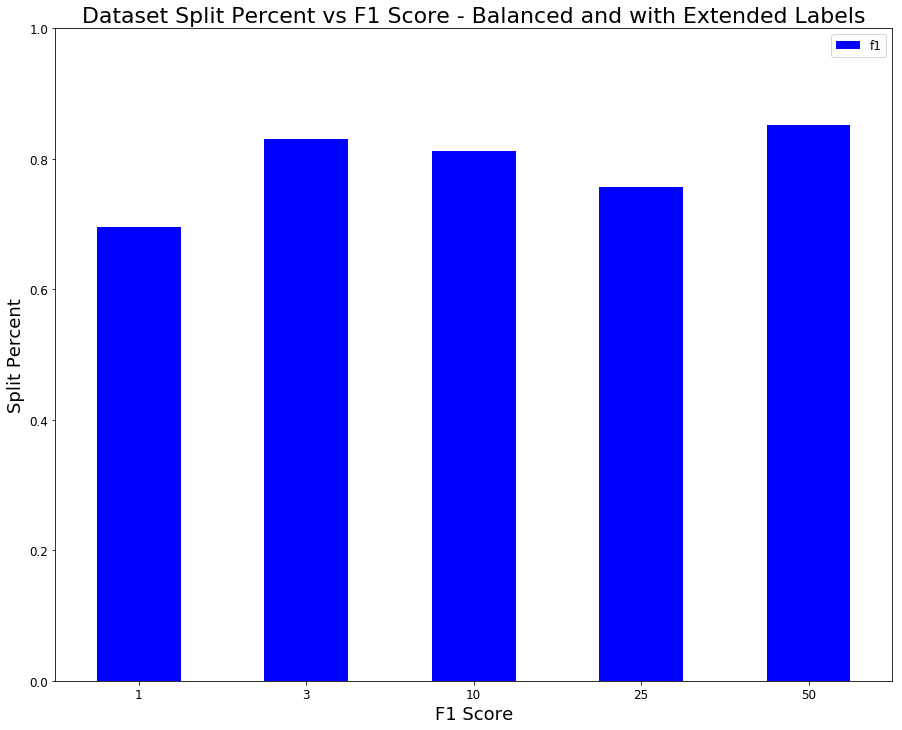

In [70]:
# Just ResNet50
display_results(distill_df[distill_df.arch == "ResNet50"])